Pixel Coordinate Prediction using Deep Learning

DeepEdge ML Assignment

Author: Rishika Rajora

Dependencies & Import

In [20]:
"""
Rationale:
1. Numpy: Used for efficient grid generation(MeshGrid) and numerical operations.
2. Matplotlib: Used for data visualization training logs and spatial predictions.
3. Scikit-learn: used for stratified/random splitting of the coordinate manifold.
4. TensorFlow/Keras: The core framework for building the CNN regression model.
"""

# Standard library imports (Numerical & Plotting)
import numpy as np
import matplotlib.pyplot as plt

# Machine learning utilities
from sklearn.model_selection import train_test_split

# Deep Learning framework components
import tensorflow as tf
from tensorflow.keras import layers, models

# Ensuring reproducibility as per Production Standards
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully. Ready for Productionized Data Engineering.")


Libraries imported successfully. Ready for Productionized Data Engineering.


Dataset Generator Function

In [24]:
import numpy as np
def generate_meshgrid_dataset(img_size=50):
    """
    Generates a deterministic dataset using a 2D meshgrid.
    Each image contains exactly one active pixel (value = 1.0).
    The target is the normalized (x, y) coordinate of the active pixel.

    Parameters
    ----------
    img_size : int
        The size of the square images.

    Returns
    -------
    images : np.ndarray
      Array of Shape(num_samples, img_size, img_size, 1)
      containing generated images.

    labels : np.ndarray
      Array of Shape(num_samples, 2) containing normalized (x, y) coordinates.
    """

    # Create a grid of all possible (x, y) pixel coordinated
    xs, ys = np.meshgrid(
        np.arange(img_size),
        np.arange(img_size)
    )

    num_samples = img_size * img_size

    # Initialize image and label arrays
    images = np.zeros((num_samples, img_size, img_size, 1), dtype=np.float32)
    labels = np.zeros((num_samples, 2), dtype=np.float32)

    index = 0

    # Iterate through each coordinate pair in the grid
    for x, y in zip(xs.flatten(), ys.flatten()):

        # Create a blank image
        img = np.zeros((img_size, img_size), dtype=np.float32)

        # Activate a single pixel at (x, y)
        img[y, x] = 1.0

        # Store image and normalized coordinated
        images[index, :, :, 0] = img
        labels[index] = [
            x / (img_size - 1),
            y / (img_size - 1)
        ]
        index += 1

    return images, labels


Rationale Behind Dataset Choice

The problem requires predicting the spatial coordinates of a single high-intensity pixel in a fixed-size grayscale image. Since the image size is 50×50 and exactly one pixel is active at a time, the input space is finite and deterministic.

To address this, the dataset is generated using a 2D meshgrid that exhaustively enumerates all possible pixel locations. This results in exactly 2500 unique samples, corresponding to every possible (x, y) coordinate in the image. Each generated image contains one active pixel at a unique location, and the corresponding label is the normalized coordinate of that pixel.

Create Dataset

In [21]:
# Generate the dataset using a meshgrid-based approach
X, y = generate_meshgrid_dataset()

# print dataset shapes to verify correctness
print("Images shape:", X.shape)
print("Labels shape:", y.shape)


Images shape: (2500, 50, 50, 1)
Labels shape: (2500, 2)


Visualize One Sample

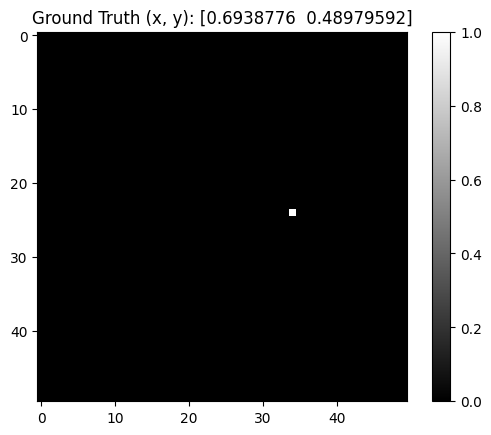

In [22]:

import matplotlib.pyplot as plt

# Index of the sample to visualize
sample_index = 1234

# Display the selected image sample
plt.imshow(X[sample_index, :, :, 0], cmap="gray")

# Set title with corresponding ground truth coordinates
plt.title(f"Ground Truth (x, y): {y[sample_index]}")

# Add color scale for pixel intensity reference
plt.colorbar()

# Render the visualization
plt.show()


Train Validation Split

In [10]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# Print sample counts to verify the split
print("Train samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])


Train samples: 2000
Validation samples: 500


Build CNN Model

In [11]:
def build_coordinate_regressor(input_shape=(50, 50, 1)):
    """
    CNN model for predicting normalized (x, y) coordinates
    from a grayscale image with one active pixel.

    Parameters
    ----------
    input_shape : tuple, optional
        The shape of the input images(height, width, channels).

    Returns
    ----------
    model : tf.keras.models.Sequential
        The compiled CNN model.
    """
    model = models.Sequential([

        # Convolution layers to extract spatial features
        layers.Conv2D(16, (3, 3), activation="relu",
                      input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),

        # Flatten spatial features into a feature vector
        layers.Flatten(),

        # Fully connected layer for coordinate regression
        layers.Dense(64, activation="relu"),

        # Output layer for normalized (x, y) prediction
        layers.Dense(2, activation="sigmoid")
    ])

    # Compile the model using MSE loss for regression
    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )

    return model


model = build_coordinate_regressor()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16928)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,083,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,088,386 (4.15 MB)

 Trainable params: 1,088,386 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

Train Model

In [12]:
# Train the CNN Model on the meshgrid-based dataset
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - loss: 0.0527 - mae: 0.1778 - val_loss: 0.0070 - val_mae: 0.0572
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - loss: 0.0046 - mae: 0.0470 - val_loss: 0.0034 - val_mae: 0.0402
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.0026 - mae: 0.0371 - val_loss: 0.0024 - val_mae: 0.0337
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - loss: 0.0020 - mae: 0.0325 - val_loss: 0.0029 - val_mae: 0.0372
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.0017 - mae: 0.0300 - val_loss: 0.0017 - val_mae: 0.0280
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - loss: 0.0012 - mae: 0.0252 - val_loss: 0.0014 - val_mae: 0.0255
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - loss: 9.5605e-04 - mae: 0.0231 - val_loss: 0.0011 - val_mae: 0.0231
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 8.3264e-04 - mae: 0.0216 - val_loss: 0.0013 - val_mae: 0.0255
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/

Training Loss Graph

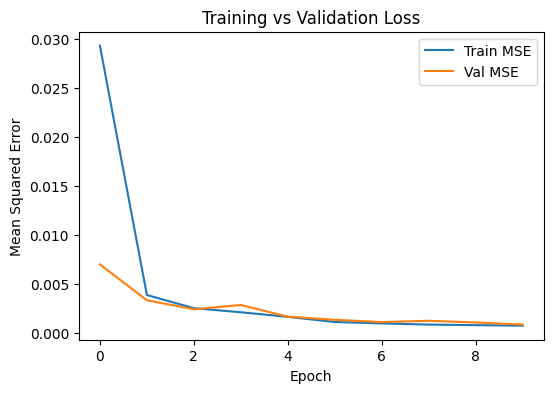

In [13]:
# Plot training and validation loss over people
plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="Train MSE")
plt.plot(history.history["val_loss"], label="Val MSE")

# Label axes and add legend
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()

# Add plot title
plt.title("Training vs Validation Loss")

# Display the plot
plt.show()


Presiction vs Ground Truth

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Ground Truth (x, y): [0.12244898 0.5714286 ]
Predicted   (x, y): [0.1484727 0.5825483]


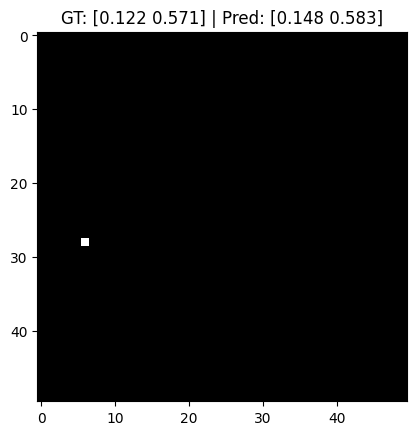

In [15]:
# Select a sample from the validation set
test_index = 200

# Predict normalized (x, y) coordinates
pred = model.predict(X_val[test_index:test_index + 1])[0]

# Ground truth coordinated
gt = y_val[test_index]

# Print prediction results
print("Ground Truth (x, y):", gt)
print("Predicted   (x, y):", pred)

# Visualize the image with prediction comparison
plt.imshow(X_val[test_index, :, :, 0], cmap="gray")
plt.title(
    f"GT: {gt.round(3)} | Pred: {pred.round(3)}"
)
plt.show()



Final Submission

In [16]:
# Evaluate the model on the validation dataset
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)

# Display final evaluation metrics
print(f"Final Validation MSE: {val_loss:.6f}")
print(f"Final Validation MAE: {val_mae:.6f}")


Final Validation MSE: 0.000884
Final Validation MAE: 0.021321
